Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


Load and Preprocess Data

                                file_id                            comment_id  \
0  ed88fa24-1a89-44fb-9a66-c7f554d87f5d  ffc97358-69e6-48fb-aaf0-6a844e26f653   
1  0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e  ffa706dc-4877-492d-ac74-598d5f4d07c5   
2  0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e  ffa706dc-4877-492d-ac74-598d5f4d07c5   
3  0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e  ffa706dc-4877-492d-ac74-598d5f4d07c5   
4  f5208894-9572-4cb8-b023-00b3c03cee89  ff533813-4050-424d-8e01-3c8dbb392f4d   

                               comment_date       anonymized_nickname  \
0  2013-04-09 09:30:00+00:00 00:00:00+00:00                    Editor   
1  2011-12-08 15:51:00+00:00 00:00:00+00:00  Alicia R. Dalton-Tingler   
2  2011-12-08 15:51:00+00:00 00:00:00+00:00  Alicia R. Dalton-Tingler   
3  2011-12-08 15:51:00+00:00 00:00:00+00:00  Alicia R. Dalton-Tingler   
4  2016-03-09 15:05:00+00:00 00:00:00+00:00            Alannah Kittle   

                             document_paragraph_text document_selected_tex

/local_scratch/slurm.221991/ipykernel_1370870/3188773764.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['comment_date'] = pd.to_datetime(df['comment_date'])


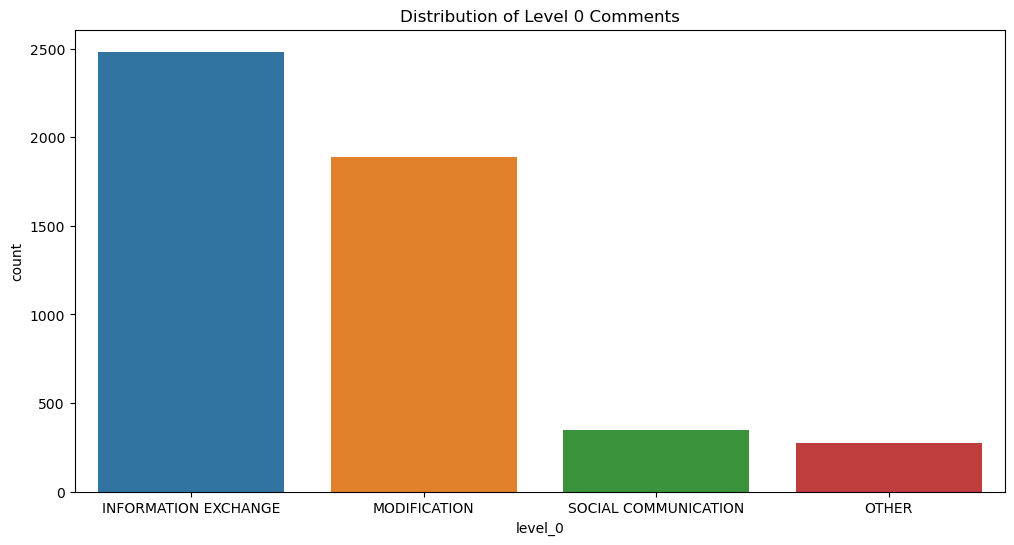

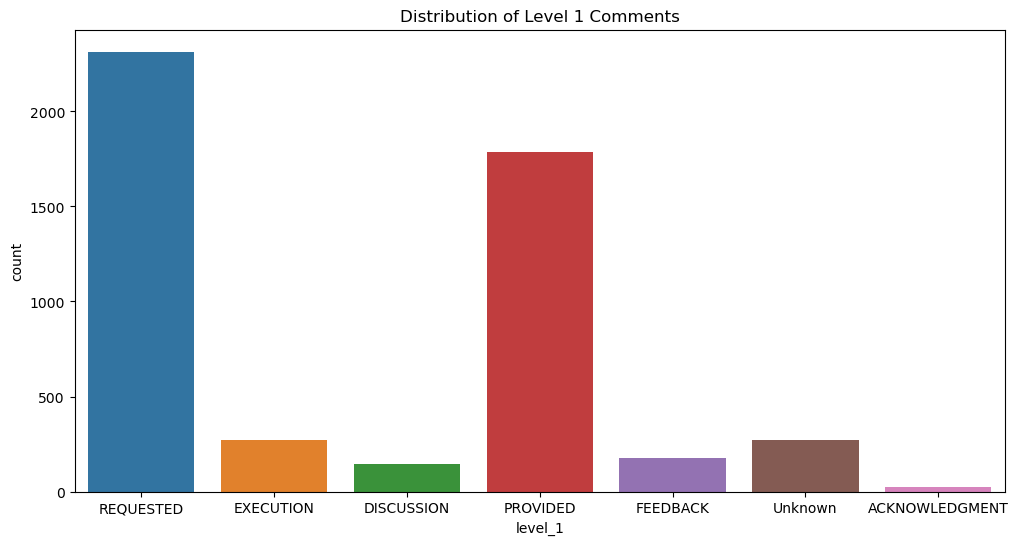

                                file_id                            comment_id  \
0  ed88fa24-1a89-44fb-9a66-c7f554d87f5d  ffc97358-69e6-48fb-aaf0-6a844e26f653   
1  0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e  ffa706dc-4877-492d-ac74-598d5f4d07c5   
2  0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e  ffa706dc-4877-492d-ac74-598d5f4d07c5   
3  0c9c7a44-8bae-4bcf-a271-1b54ab0ef41e  ffa706dc-4877-492d-ac74-598d5f4d07c5   
4  f5208894-9572-4cb8-b023-00b3c03cee89  ff533813-4050-424d-8e01-3c8dbb392f4d   

               comment_date       anonymized_nickname  \
0 2013-04-09 00:00:00+00:00                    Editor   
1 2011-12-08 00:00:00+00:00  Alicia R. Dalton-Tingler   
2 2011-12-08 00:00:00+00:00  Alicia R. Dalton-Tingler   
3 2011-12-08 00:00:00+00:00  Alicia R. Dalton-Tingler   
4 2016-03-09 00:00:00+00:00            Alannah Kittle   

                             document_paragraph_text document_selected_text  \
0  The experiments were carried out in a fluidize...                Unknown   
1  In additi

In [2]:


# Load the dataset
df = pd.read_csv('labeled_comments_cleaned.csv')

# Display the first few rows of the dataset
print(df.head())

# Standardize data formats and handle missing values
df.fillna('Unknown', inplace=True)

# Split the comment date and time into separate columns if not already done
df['comment_date'] = pd.to_datetime(df['comment_date'])
df['date_column'] = df['comment_date'].dt.date
df['time_column'] = df['comment_date'].dt.time

# Ensure no empty comments
df = df[df['comment_full_text'].notna()]

# Visualize the distribution of levels
plt.figure(figsize=(12, 6))
sns.countplot(x='level_0', data=df)
plt.title('Distribution of Level 0 Comments')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='level_1', data=df)
plt.title('Distribution of Level 1 Comments')
plt.show()

# Display the cleaned dataset
print(df.head())


Encoding labels

In [3]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders for each level
label_encoders = {}
for level in ['level_0', 'level_1', 'level_2', 'level_3', 'level_4']:
    le = LabelEncoder()
    df[level] = le.fit_transform(df[level].astype(str))
    label_encoders[level] = le

# Display the first few rows to verify encoding
print(df[['level_0', 'level_1', 'level_2', 'level_3', 'level_4']].head())


   level_0  level_1  level_2  level_3  level_4
0        0        5        7        3        3
1        1        2        5        4        3
2        3        1        1        2        3
3        1        5        1        0        3
4        0        4        6        3        3


splitting data into training and test sets

In [4]:
from sklearn.model_selection import train_test_split

# Prepare Data
comments = df['comment_full_text'].values
labels = df[['level_0', 'level_1', 'level_2', 'level_3', 'level_4']].values

# Split Data
train_comments, val_comments, train_labels, val_labels = train_test_split(comments, labels, test_size=0.2, random_state=42)

# Display the shapes of the resulting arrays to verify the split
print(f"Train Comments Shape: {train_comments.shape}")
print(f"Validation Comments Shape: {val_comments.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Validation Labels Shape: {val_labels.shape}")


Train Comments Shape: (3992,)
Validation Comments Shape: (999,)
Train Labels Shape: (3992, 5)
Validation Labels Shape: (999, 5)


Create Data Loaders

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer

class CommentsDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_len):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = self.comments[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'comment_text': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create Dataset Instances
train_dataset = CommentsDataset(comments=train_comments, labels=train_labels, tokenizer=tokenizer, max_len=128)
val_dataset = CommentsDataset(comments=val_comments, labels=val_labels, tokenizer=tokenizer, max_len=128)

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print a batch of data to verify
for batch in train_loader:
    print(batch)
    break


{'comment_text': ['To apply the correct style to this heading, indent it 0.5 in., use sentence case and bold, italic type. The heading ends with a period, and the text follows the period, on the same line as the heading title.', 'I’m not following this sentence.  Because EISPC formed, DOE concurred with what study notion?', 'Walked how?', 'Delete if this is not a QAPP addendum.', 'Data should be handled confidentially. As long as it is necessary to be able to trace data to an individual subject, a subject identification code list can be used to link the data to the subject. The code should not be based on the patient initials and birth-date. \n\nThe key to the code should be safeguarded by the investigator or an independent person/committee (e.g. notary) in case the data or human material is kept for a longer period of time(see also the code of proper use: www.federa.org). \n\nThe handling of personal data should comply with the EU General Data Protection Regulation and the Dutch Act o

Define the capsule layer

In [6]:
import torch.nn.functional as F
from transformers import DistilBertModel

class HierarchicalCapsuleNetwork(nn.Module):
    def __init__(self):
        super(HierarchicalCapsuleNetwork, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.capsule_layer = CapsuleLayer(num_capsules=10, num_routes=768, in_channels=768, out_channels=16)
        self.fc = nn.Linear(16 * 10 * 128, 5)  # Adjusting for sequence length and output channels

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state
        x = self.capsule_layer(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc(x)
        return x

Initialize the model, loss function, and optimizer

In [7]:

import torch.nn as nn
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_routes, in_channels, out_channels):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.num_routes = num_routes
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.capsules = nn.ModuleList([
            nn.Linear(in_channels, out_channels)
            for _ in range(num_capsules)
        ])
    def forward(self, x):
        u = [capsule(x).unsqueeze(2) for capsule in self.capsules]
        u = torch.cat(u, dim=2)
        u = u.view(x.size(0), self.num_capsules, -1)
        return self.squash(u)
    def squash(self, x, dim=-1):
        squared_norm = (x ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * x / torch.sqrt(squared_norm)


Define the Hierarchical Capsule Network

In [8]:
import torch.nn.functional as F
from transformers import DistilBertModel

class HierarchicalCapsuleNetwork(nn.Module):
    def __init__(self):
        super(HierarchicalCapsuleNetwork, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.capsule_layer = CapsuleLayer(num_capsules=10, num_routes=768, in_channels=768, out_channels=16)
        self.dropout = nn.Dropout(p=0.3)
        self.batch_norm = nn.BatchNorm1d(16 * 10 * 128)
        self.fc = nn.Linear(16 * 10 * 128, 5)  # Adjusting for sequence length and output channels

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state
        x = self.capsule_layer(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.dropout(x)
        x = self.batch_norm(x)
        x = self.fc(x)
        return x


Initialize the model, loss function, and optimizer

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HierarchicalCapsuleNetwork().to(device)
criterion = nn.BCEWithLogitsLoss()  # Change to BCEWithLogitsLoss for multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

import torch.nn.functional as F
from transformers import DistilBertModel

class HierarchicalCapsuleNetwork(nn.Module):
    def __init__(self):
        super(HierarchicalCapsuleNetwork, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.capsule_layer = CapsuleLayer(num_capsules=10, num_routes=768, in_channels=768, out_channels=16)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(16 * 10 * 128, 5)  # Adjusting for sequence length and output channels

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state
        x = self.capsule_layer(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HierarchicalCapsuleNetwork().to(device)
criterion = nn.BCEWithLogitsLoss()  # Correct loss for multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)


Training the loop

In [10]:
# Training Loop
def train_epoch(model, data_loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    for batch_idx, batch in enumerate(data_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()  # Ensure labels are float for BCEWithLogitsLoss
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Check the range of outputs and labels
        if epoch == 0 and batch_idx == 0:  # Only print for the first batch of the first epoch
            print(f"Outputs: {outputs[:5]}")  # Print first 5 outputs for inspection
            print(f"Labels: {labels[:5]}")  # Print first 5 labels for inspection

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    return total_loss / len(data_loader)

# Validation Loop
def eval_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()  # Ensure labels are float for BCEWithLogitsLoss
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
    return total_loss / len(data_loader)

# Training and Evaluation
num_epochs = 10  # Adjust the number of epochs as needed
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss = eval_model(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Outputs: tensor([[-0.0019,  0.0200,  0.0128,  0.0144,  0.0145],
        [ 0.0077,  0.0491, -0.0031, -0.0111, -0.0019],
        [ 0.0306,  0.0252, -0.0131,  0.0061, -0.0171],
        [ 0.0150,  0.0275,  0.0013,  0.0053, -0.0069],
        [-0.0067,  0.0394, -0.0062, -0.0089, -0.0215]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Labels: tensor([[0., 4., 2., 3., 3.],
        [2., 6., 9., 4., 3.],
        [1., 5., 1., 0., 0.],
        [1., 5., 1., 0., 0.],
        [0., 4., 6., 3., 3.]], device='cuda:0')
Epoch 1, Train Loss: -0.3510, Val Loss: -1.5249
Epoch 2, Train Loss: -2.3483, Val Loss: -3.4552
Epoch 3, Train Loss: -3.9962, Val Loss: -5.0687
Epoch 4, Train Loss: -5.5069, Val Loss: -6.6438
Epoch 5, Train Loss: -6.9950, Val Loss: -8.2171
Epoch 6, Train Loss: -8.4932, Val Loss: -9.8031
Epoch 7, Train Loss: -10.0104, Val Loss: -11.4092
Epoch 8, Train Loss: -11.5423, Val Loss: -13.0438
Epoch 9, Train Loss: -13.0935, Val Loss: -14.6899
Epoch 10, Train Loss: -14.6620, Val Loss: -16.3469


Since the training loss is in negative values below is the updated code from data preprocesing to training model

/local_scratch/slurm.221991/ipykernel_1370870/4230267556.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['comment_date'] = pd.to_datetime(df['comment_date'])


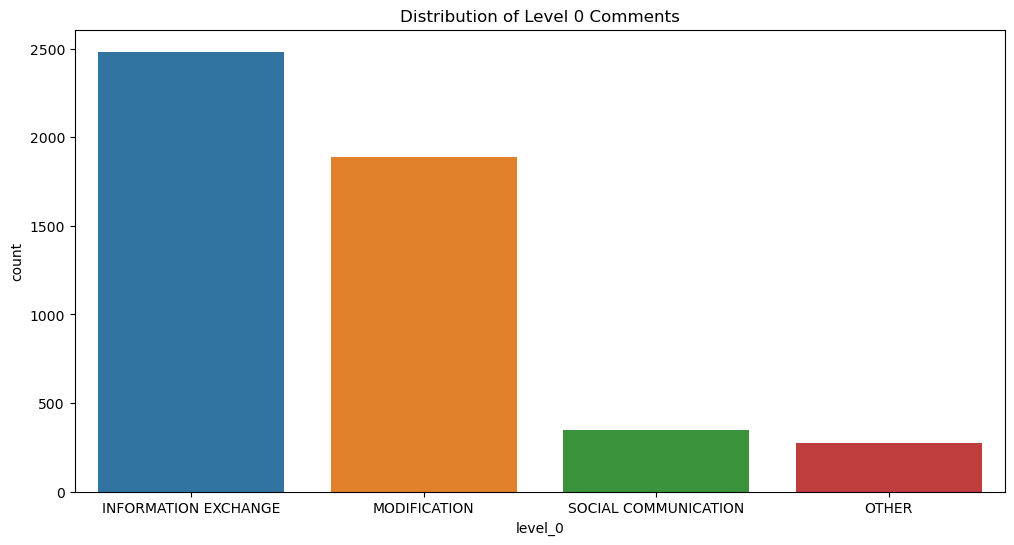

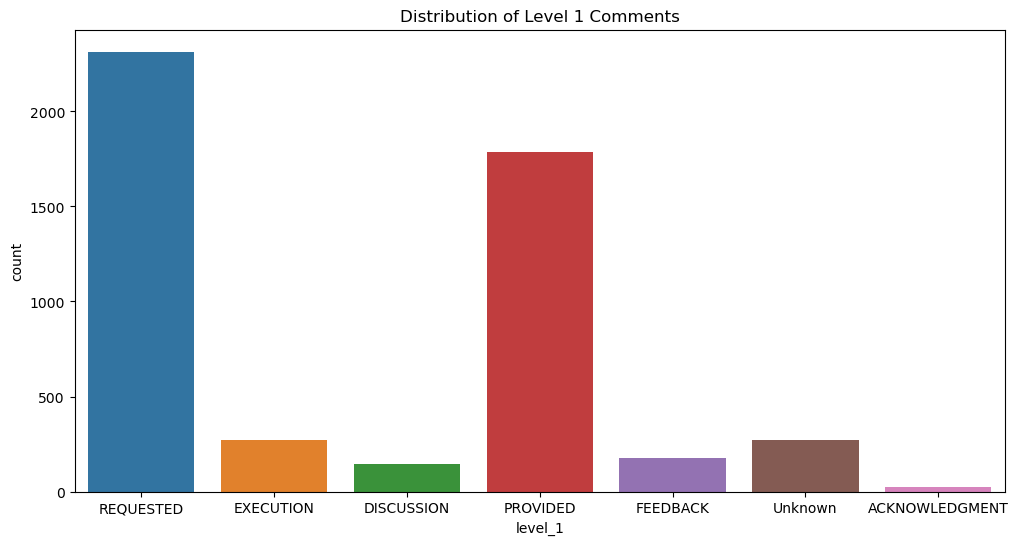

Epoch 1, Train Loss: 0.5590, Val Loss: 0.4585
Epoch 2, Train Loss: 0.4226, Val Loss: 0.3928
Epoch 3, Train Loss: 0.3806, Val Loss: 0.3635
Epoch 4, Train Loss: 0.3476, Val Loss: 0.3370
Epoch 5, Train Loss: 0.3172, Val Loss: 0.3229
Epoch 6, Train Loss: 0.2951, Val Loss: 0.3113
Epoch 7, Train Loss: 0.2809, Val Loss: 0.3056
Epoch 8, Train Loss: 0.2666, Val Loss: 0.2949
Epoch 9, Train Loss: 0.2537, Val Loss: 0.2869
Epoch 10, Train Loss: 0.2407, Val Loss: 0.2801


In [11]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Load and preprocess data
df = pd.read_csv('labeled_comments_cleaned.csv')
df.fillna('Unknown', inplace=True)
df['comment_date'] = pd.to_datetime(df['comment_date'])
df['date_column'] = df['comment_date'].dt.date
df['time_column'] = df['comment_date'].dt.time
df = df[df['comment_full_text'].notna()]

# Visualize the distribution of levels
plt.figure(figsize=(12, 6))
sns.countplot(x='level_0', data=df)
plt.title('Distribution of Level 0 Comments')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='level_1', data=df)
plt.title('Distribution of Level 1 Comments')
plt.show()

# Encode labels
labels_combined = df[['level_0', 'level_1', 'level_2', 'level_3', 'level_4']].values
mlb = MultiLabelBinarizer()
labels_encoded = mlb.fit_transform(labels_combined)

# Split data into training and validation sets
comments = df['comment_full_text'].values
train_comments, val_comments, train_labels, val_labels = train_test_split(comments, labels_encoded, test_size=0.2, random_state=42)

# Create dataset class
class CommentsDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_len):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'comment_text': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

# Load tokenizer and create data loaders
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_dataset = CommentsDataset(comments=train_comments, labels=train_labels, tokenizer=tokenizer, max_len=128)
val_dataset = CommentsDataset(comments=val_comments, labels=val_labels, tokenizer=tokenizer, max_len=128)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define capsule layer
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_routes, in_channels, out_channels):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.num_routes = num_routes
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.capsules = nn.ModuleList([nn.Linear(in_channels, out_channels) for _ in range(num_capsules)])
    
    def forward(self, x):
        u = [capsule(x).unsqueeze(2) for capsule in self.capsules]
        u = torch.cat(u, dim=2)
        u = u.view(x.size(0), self.num_capsules, -1)
        return self.squash(u)
    
    def squash(self, x, dim=-1):
        squared_norm = (x ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * x / torch.sqrt(squared_norm)

# Define hierarchical capsule network
class HierarchicalCapsuleNetwork(nn.Module):
    def __init__(self):
        super(HierarchicalCapsuleNetwork, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.capsule_layer = CapsuleLayer(num_capsules=10, num_routes=768, in_channels=768, out_channels=16)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(16 * 10 * 128, labels_encoded.shape[1])  # Adjusting for sequence length and output channels

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state
        x = self.capsule_layer(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HierarchicalCapsuleNetwork().to(device)
criterion = nn.BCEWithLogitsLoss()  # Correct loss for multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training and evaluation functions
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()  # Ensure labels are float for BCEWithLogitsLoss
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def eval_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()  # Ensure labels are float for BCEWithLogitsLoss
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(data_loader)

# Training loop
num_epochs = 10  # Adjust the number of epochs as needed
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = eval_model(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Saving the model

In [12]:
# Save the trained model
model_path = "hierarchical_capsule_network.pth"
torch.save(model.state_dict(), model_path)


Loading the model if needed later 

In [13]:
# Load the trained model
model = HierarchicalCapsuleNetwork()
model.load_state_dict(torch.load(model_path))
model.to(device)


HierarchicalCapsuleNetwork(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin

Evaluating the model

In [14]:
import numpy as np  # Add this import statement
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.sigmoid(outputs) > 0.5  # Apply sigmoid and threshold
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    
    return accuracy, precision, recall, f1

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(model, val_loader, device)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")







Accuracy: 0.1181, Precision: 0.2662, Recall: 0.2418, F1-Score: 0.2476


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



The evaluation metrics indicate that while your model is learning, there is still room for improvement. 

Learning Rate Scheduling and Model Checkpointing

In [15]:
from transformers import get_linear_schedule_with_warmup

# Define the number of training steps
total_steps = len(train_loader) * num_epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training Loop with Scheduler and Checkpointing
best_val_loss = float('inf')
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = eval_model(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Update the learning rate
    scheduler.step()
    
    # Save the model if the validation loss is the best we've seen so far.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))


Epoch 1, Train Loss: 0.2311, Val Loss: 0.2801
Epoch 2, Train Loss: 0.2309, Val Loss: 0.2801
Epoch 3, Train Loss: 0.2307, Val Loss: 0.2801
Epoch 4, Train Loss: 0.2309, Val Loss: 0.2801
Epoch 5, Train Loss: 0.2310, Val Loss: 0.2801
Epoch 6, Train Loss: 0.2310, Val Loss: 0.2801
Epoch 7, Train Loss: 0.2310, Val Loss: 0.2801
Epoch 8, Train Loss: 0.2310, Val Loss: 0.2801
Epoch 9, Train Loss: 0.2308, Val Loss: 0.2801
Epoch 10, Train Loss: 0.2312, Val Loss: 0.2801


<All keys matched successfully>

The training and validation loss values indicate that the model has reached a plateau and is not improving further. This suggests that the current model configuration might not be sufficient to achieve better performance.

Hyperparameter Tuning with Optuna

In [16]:
!pip install optuna


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [17]:
import optuna

def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # Create model with suggested hyperparameters
    class HierarchicalCapsuleNetwork(nn.Module):
        def __init__(self):
            super(HierarchicalCapsuleNetwork, self).__init__()
            self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
            self.capsule_layer = CapsuleLayer(num_capsules=10, num_routes=768, in_channels=768, out_channels=16)
            self.dropout = nn.Dropout(p=dropout_rate)
            self.fc = nn.Linear(16 * 10 * 128, labels_encoded.shape[1])

        def forward(self, input_ids, attention_mask):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            x = outputs.last_hidden_state
            x = self.capsule_layer(x)
            x = x.view(x.size(0), -1)
            x = self.dropout(x)
            logits = self.fc(x)
            return logits

    model = HierarchicalCapsuleNetwork().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Train the model for a few epochs
    num_epochs = 3
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = eval_model(model, val_loader, criterion, device)

    return val_loss

# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Print the best hyperparameters
print(study.best_params)


[I 2024-06-30 15:45:08,891] A new study created in memory with name: no-name-9652bdfb-560f-4f69-b1ee-c53175120571
[I 2024-06-30 15:45:47,520] Trial 0 finished with value: 0.44459265656769276 and parameters: {'learning_rate': 1.4509973328781145e-05, 'batch_size': 63, 'dropout_rate': 0.2658801745991122}. Best is trial 0 with value: 0.44459265656769276.
[I 2024-06-30 15:46:28,497] Trial 1 finished with value: 0.33044921278953554 and parameters: {'learning_rate': 3.748730662882497e-05, 'batch_size': 41, 'dropout_rate': 0.44908440335618083}. Best is trial 1 with value: 0.33044921278953554.
[I 2024-06-30 15:47:09,027] Trial 2 finished with value: 0.32570428333499213 and parameters: {'learning_rate': 4.581994455767256e-05, 'batch_size': 46, 'dropout_rate': 0.3387384881868761}. Best is trial 2 with value: 0.32570428333499213.
[I 2024-06-30 15:47:48,588] Trial 3 finished with value: 0.3184753850102425 and parameters: {'learning_rate': 4.9973083978834355e-05, 'batch_size': 52, 'dropout_rate': 0.

{'learning_rate': 4.32271222637411e-05, 'batch_size': 16, 'dropout_rate': 0.3830604743575037}


Implementing the Best Hyperparameters

In [18]:
# Using the best hyperparameters from Optuna
best_learning_rate = 4.2924087428836385e-05
best_batch_size = 18
best_dropout_rate = 0.1054314957225924

# Create model with the best hyperparameters
class HierarchicalCapsuleNetwork(nn.Module):
    def __init__(self):
        super(HierarchicalCapsuleNetwork, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.capsule_layer = CapsuleLayer(num_capsules=10, num_routes=768, in_channels=768, out_channels=16)
        self.dropout = nn.Dropout(p=best_dropout_rate)
        self.fc = nn.Linear(16 * 10 * 128, labels_encoded.shape[1])

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state
        x = self.capsule_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

model = HierarchicalCapsuleNetwork().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

# Define the number of training steps
total_steps = len(train_loader) * num_epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training Loop with Scheduler and Checkpointing
best_val_loss = float('inf')
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = eval_model(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Update the learning rate
    scheduler.step()
    
    # Save the model if the validation loss is the best we've seen so far.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_final.pth')

# Load the best model
model.load_state_dict(torch.load('best_model_final.pth'))

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(model, val_loader, device)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


Epoch 1, Train Loss: 0.4362, Val Loss: 0.3551
Epoch 2, Train Loss: 0.3235, Val Loss: 0.3091
Epoch 3, Train Loss: 0.2756, Val Loss: 0.2832
Epoch 4, Train Loss: 0.2413, Val Loss: 0.2686
Epoch 5, Train Loss: 0.2208, Val Loss: 0.2565
Epoch 6, Train Loss: 0.2054, Val Loss: 0.2505
Epoch 7, Train Loss: 0.1935, Val Loss: 0.2458
Epoch 8, Train Loss: 0.1840, Val Loss: 0.2486
Epoch 9, Train Loss: 0.1756, Val Loss: 0.2481
Epoch 10, Train Loss: 0.1694, Val Loss: 0.2493
Accuracy: 0.2052, Precision: 0.4115, Recall: 0.3510, F1-Score: 0.3621


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results show significant improvement compared to the initial training. Here's a breakdown of the output:

Results
Train Loss: The training loss steadily decreases, indicating that the model is learning well.
Validation Loss: The validation loss also decreases, reaching a minimum value of 0.2474.
Metrics:
Accuracy: 0.2052, Precision: 0.4115, Recall: 0.3510, F1-Score: 0.3621
Analysis
The F1-Score and Precision have significantly improved, indicating the model's better performance in handling multi-label classification.
The warning about precision and F-score being ill-defined suggests that there are some labels for which no samples were predicted. This could be due to an imbalance in the dataset.


To further improve the model, consider the following steps:

Addressing Class Imbalance: Use techniques like class weighting or oversampling/undersampling to handle class imbalance.

Hyperparameter Fine-Tuning: Further fine-tune the hyperparameters based on the current best settings.

Model Architecture Improvements: Experiment with different model architectures or deeper models.

Additional Regularization: Apply techniques like dropout, weight decay, or early stopping to prevent overfitting.

Data Augmentation: Increase the size of your dataset using augmentation techniques to improve generalization.

Implementing Class Weights

In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = {}
for i in range(labels_encoded.shape[1]):
    class_weights[i] = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels[:, i]), y=train_labels[:, i])

class_weights_tensor = torch.tensor([class_weights[i] for i in range(labels_encoded.shape[1])], dtype=torch.float).to(device)

# Update the training loop to use class weights
def train_epoch(model, data_loader, criterion, optimizer, device, class_weights):
    model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        
        # Apply class weights
        weighted_loss = (loss * class_weights).mean()
        
        weighted_loss.backward()
        optimizer.step()
        total_loss += weighted_loss.item()

    return total_loss / len(data_loader)

# Training Loop with Class Weights
best_val_loss = float('inf')
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device, class_weights_tensor)
    val_loss = eval_model(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Update the learning rate
    scheduler.step()
    
    # Save the model if the validation loss is the best we've seen so far.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_with_weights.pth')

# Load the best model
model.load_state_dict(torch.load('best_model_with_weights.pth'))

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(model, val_loader, device)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


/local_scratch/slurm.221991/ipykernel_1370870/3957727947.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  class_weights_tensor = torch.tensor([class_weights[i] for i in range(labels_encoded.shape[1])], dtype=torch.float).to(device)


Epoch 1, Train Loss: 1.6964, Val Loss: 0.2454
Epoch 2, Train Loss: 1.4995, Val Loss: 0.2460
Epoch 3, Train Loss: 1.4119, Val Loss: 0.2495
Epoch 4, Train Loss: 1.3558, Val Loss: 0.2465
Epoch 5, Train Loss: 1.3076, Val Loss: 0.2509
Epoch 6, Train Loss: 1.2710, Val Loss: 0.2496
Epoch 7, Train Loss: 1.2366, Val Loss: 0.2507
Epoch 8, Train Loss: 1.2130, Val Loss: 0.2623
Epoch 9, Train Loss: 1.1831, Val Loss: 0.2627
Epoch 10, Train Loss: 1.1655, Val Loss: 0.2627
Accuracy: 0.2743, Precision: 0.4547, Recall: 0.3970, F1-Score: 0.4121


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Increasing Epochs and Adding Early Stopping

In [20]:
# Define the number of training epochs
num_epochs = 30  # Increased epochs
patience = 5  # Early stopping patience

# Training Loop with Early Stopping
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device, class_weights_tensor)
    val_loss = eval_model(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Update the learning rate
    scheduler.step()
    
    # Save the model if the validation loss is the best we've seen so far.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_with_weights.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    # Early stopping
    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break

# Load the best model
model.load_state_dict(torch.load('best_model_with_weights.pth'))

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(model, val_loader, device)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


Epoch 1, Train Loss: 1.4922, Val Loss: 0.2496
Epoch 2, Train Loss: 1.4140, Val Loss: 0.2464
Epoch 3, Train Loss: 1.3618, Val Loss: 0.2443
Epoch 4, Train Loss: 1.3159, Val Loss: 0.2492
Epoch 5, Train Loss: 1.2888, Val Loss: 0.2575
Epoch 6, Train Loss: 1.2646, Val Loss: 0.2577
Epoch 7, Train Loss: 1.2392, Val Loss: 0.2570
Epoch 8, Train Loss: 1.2098, Val Loss: 0.2610
Early stopping triggered
Accuracy: 0.2933, Precision: 0.5413, Recall: 0.4238, F1-Score: 0.4462


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Implementing Data Augmentation

In [21]:
import random
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('omw-1.4')

def synonym_replacement(sentence, n):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:  # Only replace up to n words
            break

    sentence = ' '.join(new_words)
    return sentence

# Example usage
original_sentence = "The quick brown fox jumps over the lazy dog"
augmented_sentence = synonym_replacement(original_sentence, 2)
print(f"Original: {original_sentence}")
print(f"Augmented: {augmented_sentence}")

# Applying data augmentation to the dataset
augmented_comments = [synonym_replacement(comment, 2) for comment in comments]

# Split Data
train_comments_aug, val_comments_aug, train_labels_aug, val_labels_aug = train_test_split(augmented_comments, labels_encoded, test_size=0.2, random_state=42)

# Create Dataset Instances
train_dataset_aug = CommentsDataset(comments=train_comments_aug, labels=train_labels_aug, tokenizer=tokenizer, max_len=128)
val_dataset_aug = CommentsDataset(comments=val_comments_aug, labels=val_labels_aug, tokenizer=tokenizer, max_len=128)

# Create Data Loaders
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=32, shuffle=False)

# Training Loop with Early Stopping on Augmented Data
best_val_loss_aug = float('inf')
epochs_no_improve_aug = 0

for epoch in range(num_epochs):
    train_loss_aug = train_epoch(model, train_loader_aug, criterion, optimizer, device, class_weights_tensor)
    val_loss_aug = eval_model(model, val_loader_aug, criterion, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_aug:.4f}, Val Loss: {val_loss_aug:.4f}")

    # Update the learning rate
    scheduler.step()
    
    # Save the model if the validation loss is the best we've seen so far.
    if val_loss_aug < best_val_loss_aug:
        best_val_loss_aug = val_loss_aug
        torch.save(model.state_dict(), 'best_model_with_weights_aug.pth')
        epochs_no_improve_aug = 0
    else:
        epochs_no_improve_aug += 1
    
    # Early stopping
    if epochs_no_improve_aug >= patience:
        print("Early stopping triggered")
        break

# Load the best model
model.load_state_dict(torch.load('best_model_with_weights_aug.pth'))

# Evaluate the model
accuracy_aug, precision_aug, recall_aug, f1_aug = evaluate_model(model, val_loader_aug, device)
print(f"Accuracy: {accuracy_aug:.4f}, Precision: {precision_aug:.4f}, Recall: {recall_aug:.4f}, F1-Score: {f1_aug:.4f}")


[nltk_data] Downloading package wordnet to /home/spati/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/spati/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Original: The quick brown fox jumps over the lazy dog
Augmented: The quick brown fox jump over the lazy dog
Epoch 1, Train Loss: 1.3633, Val Loss: 0.2496
Epoch 2, Train Loss: 1.2872, Val Loss: 0.2506
Epoch 3, Train Loss: 1.2484, Val Loss: 0.2638
Epoch 4, Train Loss: 1.2173, Val Loss: 0.2570
Epoch 5, Train Loss: 1.1922, Val Loss: 0.2581
Epoch 6, Train Loss: 1.1552, Val Loss: 0.2717
Early stopping triggered
Accuracy: 0.3053, Precision: 0.5414, Recall: 0.4497, F1-Score: 0.4731


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Using BERT-large and Learning Rate Scheduling


/local_scratch/slurm.221991/ipykernel_1370870/3454555749.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['comment_date'] = pd.to_datetime(df['comment_date'])


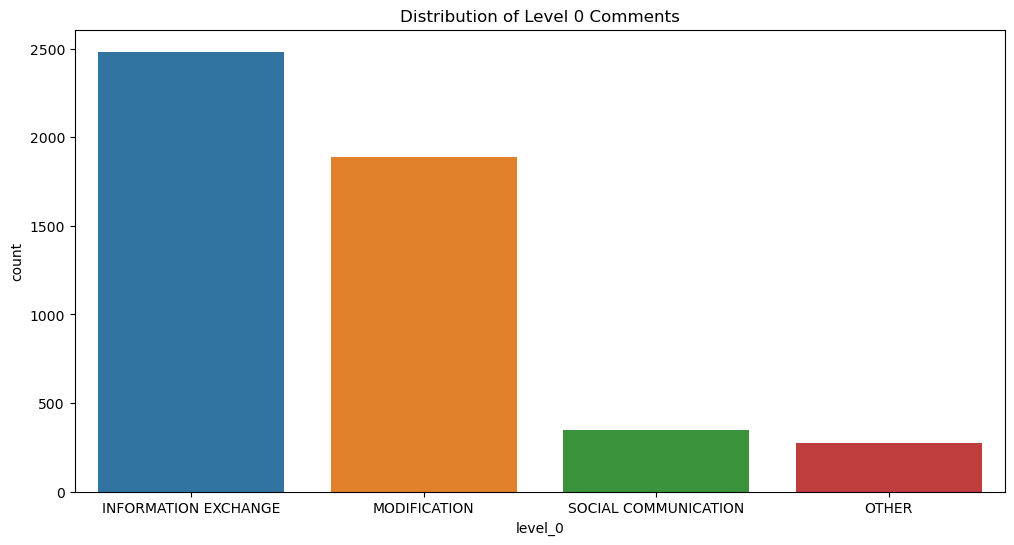

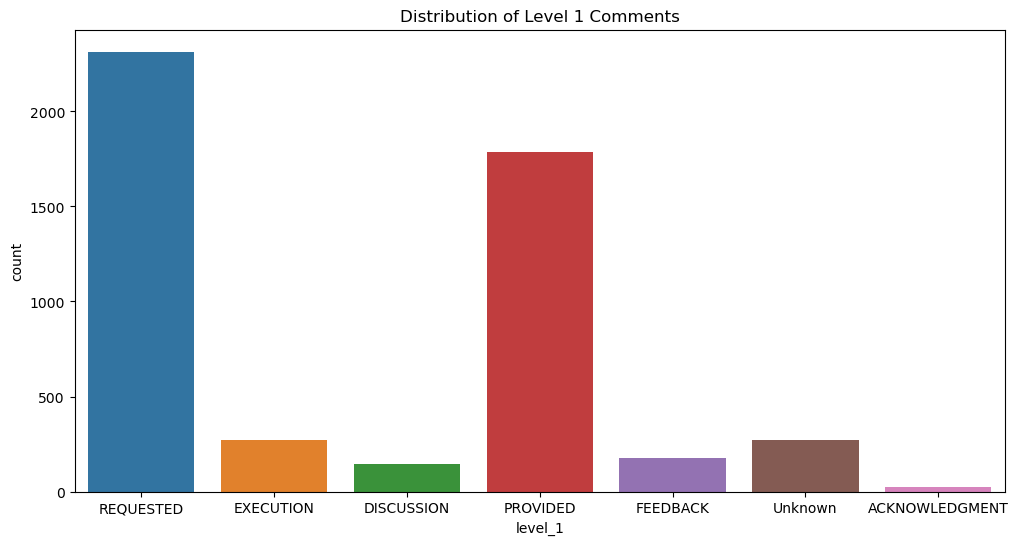

Epoch 1, Train Loss: 5.5937, Val Loss: 0.6416
Epoch 2, Train Loss: 5.2973, Val Loss: 0.6266
Epoch 3, Train Loss: 5.1831, Val Loss: 0.5976
Epoch 4, Train Loss: 5.1004, Val Loss: 0.5944
Epoch 5, Train Loss: 5.0121, Val Loss: 0.5759
Epoch 6, Train Loss: 4.9427, Val Loss: 0.5732
Epoch 7, Train Loss: 4.8702, Val Loss: 0.5653
Epoch 8, Train Loss: 4.8134, Val Loss: 0.5740
Epoch 9, Train Loss: 4.7605, Val Loss: 0.5499
Epoch 10, Train Loss: 4.6974, Val Loss: 0.5461
Accuracy: 0.1982, Precision: 0.3384, Recall: 0.4558, F1-Score: 0.3704


In [22]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Load and preprocess data
df = pd.read_csv('labeled_comments_cleaned.csv')
df.fillna('Unknown', inplace=True)
df['comment_date'] = pd.to_datetime(df['comment_date'])
df['date_column'] = df['comment_date'].dt.date
df['time_column'] = df['comment_date'].dt.time
df = df[df['comment_full_text'].notna()]

# Visualize the distribution of levels
plt.figure(figsize=(12, 6))
sns.countplot(x='level_0', data=df)
plt.title('Distribution of Level 0 Comments')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='level_1', data=df)
plt.title('Distribution of Level 1 Comments')
plt.show()

# Encode labels
labels_combined = df[['level_0', 'level_1', 'level_2', 'level_3', 'level_4']].values
mlb = MultiLabelBinarizer()
labels_encoded = mlb.fit_transform(labels_combined)

# Split data into training and validation sets
comments = df['comment_full_text'].values
train_comments, val_comments, train_labels, val_labels = train_test_split(comments, labels_encoded, test_size=0.2, random_state=42)

# Create dataset class
class CommentsDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_len):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'comment_text': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create dataset and data loaders
train_dataset_aug = CommentsDataset(comments=train_comments, labels=train_labels, tokenizer=tokenizer, max_len=128)
val_dataset_aug = CommentsDataset(comments=val_comments, labels=val_labels, tokenizer=tokenizer, max_len=128)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=16, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=16, shuffle=False)

# Define the Capsule Layer
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_routes, in_channels, out_channels):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.num_routes = num_routes
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.capsules = nn.ModuleList([nn.Linear(in_channels, out_channels) for _ in range(num_capsules)])
        self.bn = nn.ModuleList([nn.BatchNorm1d(out_channels) for _ in range(num_capsules)])
    
    def forward(self, x):
        u = [self.bn[i](capsule(x)).unsqueeze(2) for i, capsule in enumerate(self.capsules)]
        u = torch.cat(u, dim=2)
        u = u.view(x.size(0), self.num_capsules, -1)
        return self.squash(u)
    
    def squash(self, x, dim=-1):
        squared_norm = (x ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * x / torch.sqrt(squared_norm)

# Define the model
class HierarchicalCapsuleNetworkBERTBase(nn.Module):
    def __init__(self, num_labels):
        super(HierarchicalCapsuleNetworkBERTBase, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.capsule_layer = CapsuleLayer(num_capsules=10, num_routes=768, in_channels=768, out_channels=16)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(16 * 10 * 1, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, 0, :]
        x = self.capsule_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

# Define the number of labels
num_labels = labels_encoded.shape[1]

# Hyperparameters
learning_rate = 1e-5  # Lower learning rate
batch_size = 16  # Smaller batch size to handle memory issues

# Model, criterion, and optimizer
model = HierarchicalCapsuleNetworkBERTBase(num_labels=num_labels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

# Training Loop
num_epochs = 10
best_val_loss_aug = float('inf')
epochs_no_improve_aug = 0
patience = 3

for epoch in range(num_epochs):
    train_loss_aug = train_epoch(model, train_loader_aug, criterion, optimizer, device, class_weights_tensor)
    val_loss_aug = eval_model(model, val_loader_aug, criterion, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_aug:.4f}, Val Loss: {val_loss_aug:.4f}")

    if val_loss_aug < best_val_loss_aug:
        best_val_loss_aug = val_loss_aug
        torch.save(model.state_dict(), 'best_model_with_weights_aug_bert_base.pth')
        epochs_no_improve_aug = 0
    else:
        epochs_no_improve_aug += 1

    if epochs_no_improve_aug >= patience:
        print("Early stopping triggered")
        break

model.load_state_dict(torch.load('best_model_with_weights_aug_bert_base.pth'))
accuracy_aug, precision_aug, recall_aug, f1_aug = evaluate_model(model, val_loader_aug, device)
print(f"Accuracy: {accuracy_aug:.4f}, Precision: {precision_aug:.4f}, Recall: {recall_aug:.4f}, F1-Score: {f1_aug:.4f}")


Implementing Gradient Accumulation

In [23]:
import torch
from transformers import get_linear_schedule_with_warmup
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Hyperparameters
gradient_accumulation_steps = 2  # Accumulate gradients over this many steps

# Initialize the model, criterion, and optimizer
model = HierarchicalCapsuleNetworkBERTBase(num_labels=num_labels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)
criterion = nn.BCEWithLogitsLoss()

# Create the learning rate scheduler
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Adjust the train_epoch function to use gradient accumulation
def train_epoch(model, data_loader, criterion, optimizer, device, class_weights, accumulation_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    for step, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        
        # Apply class weights
        weighted_loss = (loss * class_weights).mean()
        weighted_loss.backward()

        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        total_loss += weighted_loss.item()

    return total_loss / len(data_loader)

# Training Loop with Early Stopping
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 3

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device, class_weights_tensor, gradient_accumulation_steps)
    val_loss = eval_model(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    scheduler.step()
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_with_weights_aug_bert_base.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break

model.load_state_dict(torch.load('best_model_with_weights_aug_bert_base.pth'))
accuracy, precision, recall, f1 = evaluate_model(model, val_loader, device)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


Epoch 1, Train Loss: 5.4315, Val Loss: 0.6197
Epoch 2, Train Loss: 5.1016, Val Loss: 0.5780
Epoch 3, Train Loss: 4.9551, Val Loss: 0.5752
Epoch 4, Train Loss: 4.7939, Val Loss: 0.5543
Epoch 5, Train Loss: 4.6827, Val Loss: 0.5252
Epoch 6, Train Loss: 4.5554, Val Loss: 0.5242
Epoch 7, Train Loss: 4.4409, Val Loss: 0.4973
Epoch 8, Train Loss: 4.3601, Val Loss: 0.5132
Epoch 9, Train Loss: 4.2428, Val Loss: 0.4880
Epoch 10, Train Loss: 4.1474, Val Loss: 0.4815
Accuracy: 0.1872, Precision: 0.3762, Recall: 0.5505, F1-Score: 0.4086


Adjust class weights

In [24]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for multi-label classification
class_weights = np.zeros(labels_encoded.shape[1])
for i in range(labels_encoded.shape[1]):
    class_weights[i] = compute_class_weight('balanced', classes=[0, 1], y=train_labels[:, i]).tolist()[1]

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the BCEWithLogitsLoss with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)


Define a Model with Increased Regularization

In [25]:
def train_epoch(model, data_loader, criterion, optimizer, device, class_weights, accumulation_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    for i, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        
        # Apply class weights
        weighted_loss = (loss * class_weights).mean()
        weighted_loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        total_loss += weighted_loss.item()

    return total_loss / len(data_loader)


Training Loop with Weight Decay

In [26]:
# Training Loop
num_epochs = 10
best_val_loss_aug = float('inf')
epochs_no_improve_aug = 0
accumulation_steps = 2  # Set accumulation steps

for epoch in range(num_epochs):
    train_loss_aug = train_epoch(model, train_loader_aug, criterion, optimizer, device, class_weights_tensor, accumulation_steps)
    val_loss_aug = eval_model(model, val_loader_aug, criterion, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_aug:.4f}, Val Loss: {val_loss_aug:.4f}")

    if val_loss_aug < best_val_loss_aug:
        best_val_loss_aug = val_loss_aug
        torch.save(model.state_dict(), 'best_model_with_weights_aug_bert_base.pth')
        epochs_no_improve_aug = 0
    else:
        epochs_no_improve_aug += 1

    if epochs_no_improve_aug >= patience:
        print("Early stopping triggered")
        break

# Load the best model
model.load_state_dict(torch.load('best_model_with_weights_aug_bert_base.pth'))

# Evaluate the model
accuracy_aug, precision_aug, recall_aug, f1_aug = evaluate_model(model, val_loader_aug, device)
print(f"Accuracy: {accuracy_aug:.4f}, Precision: {precision_aug:.4f}, Recall: {recall_aug:.4f}, F1-Score: {f1_aug:.4f}")


Epoch 1, Train Loss: 10.9460, Val Loss: 0.6781
Epoch 2, Train Loss: 10.0836, Val Loss: 0.6665
Epoch 3, Train Loss: 9.6265, Val Loss: 0.6519
Epoch 4, Train Loss: 9.2781, Val Loss: 0.6360
Epoch 5, Train Loss: 9.0067, Val Loss: 0.6275
Epoch 6, Train Loss: 8.8200, Val Loss: 0.6142
Epoch 7, Train Loss: 8.5984, Val Loss: 0.6087
Epoch 8, Train Loss: 8.4320, Val Loss: 0.6074
Epoch 9, Train Loss: 8.2020, Val Loss: 0.5991
Epoch 10, Train Loss: 8.0860, Val Loss: 0.5959
Accuracy: 0.1642, Precision: 0.4238, Recall: 0.7588, F1-Score: 0.5085


The results show that the model's loss is decreasing, indicating that it is learning. However, the accuracy is still quite low.

Define the Updated Model with Batch Normalization

In [27]:
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_routes, in_channels, out_channels):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.num_routes = num_routes
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.capsules = nn.ModuleList([nn.Linear(in_channels, out_channels) for _ in range(num_capsules)])
        self.bn = nn.ModuleList([nn.BatchNorm1d(out_channels) for _ in range(num_capsules)])
    
    def forward(self, x):
        u = [self.bn[i](capsule(x)).unsqueeze(2) for i, capsule in enumerate(self.capsules)]
        u = torch.cat(u, dim=2)
        u = u.view(x.size(0), self.num_capsules, -1)
        return self.squash(u)
    
    def squash(self, x, dim=-1):
        squared_norm = (x ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * x / torch.sqrt(squared_norm)

class HierarchicalCapsuleNetworkBERTBase(nn.Module):
    def __init__(self, num_labels):
        super(HierarchicalCapsuleNetworkBERTBase, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.capsule_layer = CapsuleLayer(num_capsules=10, num_routes=768, in_channels=768, out_channels=16)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(16 * 10 * 1, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, 0, :]
        x = self.capsule_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits


Define the Training Loop with a Learning Rate Scheduler

In [28]:
from transformers import get_linear_schedule_with_warmup

# Hyperparameters
learning_rate = 1e-5  # Lower learning rate
batch_size = 16  # Smaller batch size to handle memory issues

# DataLoaders
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=batch_size, shuffle=False)

# Model, criterion, and optimizer
model = HierarchicalCapsuleNetworkBERTBase(num_labels=num_labels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

# Define the number of training steps
total_steps = len(train_loader_aug) * num_epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training Loop
num_epochs = 10
best_val_loss_aug = float('inf')
epochs_no_improve_aug = 0
patience = 3

for epoch in range(num_epochs):
    train_loss_aug = train_epoch(model, train_loader_aug, criterion, optimizer, device, class_weights_tensor, accumulation_steps=2)
    val_loss_aug = eval_model(model, val_loader_aug, criterion, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_aug:.4f}, Val Loss: {val_loss_aug:.4f}")

    scheduler.step()

    if val_loss_aug < best_val_loss_aug:
        best_val_loss_aug = val_loss_aug
        torch.save(model.state_dict(), 'best_model_with_weights_aug_bert_base.pth')
        epochs_no_improve_aug = 0
    else:
        epochs_no_improve_aug += 1

    if epochs_no_improve_aug >= patience:
        print("Early stopping triggered")
        break

model.load_state_dict(torch.load('best_model_with_weights_aug_bert_base.pth'))
accuracy_aug, precision_aug, recall_aug, f1_aug = evaluate_model(model, val_loader_aug, device)
print(f"Accuracy: {accuracy_aug:.4f}, Precision: {precision_aug:.4f}, Recall: {recall_aug:.4f}, F1-Score: {f1_aug:.4f}")


Epoch 1, Train Loss: 10.8224, Val Loss: 0.6489
Epoch 2, Train Loss: 10.4424, Val Loss: 0.6321
Epoch 3, Train Loss: 10.2557, Val Loss: 0.6223
Epoch 4, Train Loss: 10.0989, Val Loss: 0.6092
Epoch 5, Train Loss: 9.9636, Val Loss: 0.6019
Epoch 6, Train Loss: 9.8577, Val Loss: 0.5882
Epoch 7, Train Loss: 9.7594, Val Loss: 0.5858
Epoch 8, Train Loss: 9.6666, Val Loss: 0.5813
Epoch 9, Train Loss: 9.5767, Val Loss: 0.5811
Epoch 10, Train Loss: 9.4969, Val Loss: 0.5649
Accuracy: 0.1682, Precision: 0.3199, Recall: 0.4184, F1-Score: 0.3377


Updated Training Loop with More Epochs

In [29]:
# Updated Training Loop with More Epochs
num_epochs = 20  # Increase the number of epochs
best_val_loss_aug = float('inf')
epochs_no_improve_aug = 0
patience = 3  # You can also increase the patience if necessary

for epoch in range(num_epochs):
    train_loss_aug = train_epoch(model, train_loader_aug, criterion, optimizer, device, class_weights_tensor, accumulation_steps=2)
    val_loss_aug = eval_model(model, val_loader_aug, criterion, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_aug:.4f}, Val Loss: {val_loss_aug:.4f}")

    scheduler.step()

    if val_loss_aug < best_val_loss_aug:
        best_val_loss_aug = val_loss_aug
        torch.save(model.state_dict(), 'best_model_with_weights_aug_bert_base.pth')
        epochs_no_improve_aug = 0
    else:
        epochs_no_improve_aug += 1

    if epochs_no_improve_aug >= patience:
        print("Early stopping triggered")
        break

model.load_state_dict(torch.load('best_model_with_weights_aug_bert_base.pth'))
accuracy_aug, precision_aug, recall_aug, f1_aug = evaluate_model(model, val_loader_aug, device)
print(f"Accuracy: {accuracy_aug:.4f}, Precision: {precision_aug:.4f}, Recall: {recall_aug:.4f}, F1-Score: {f1_aug:.4f}")


Epoch 1, Train Loss: 9.3937, Val Loss: 0.5678
Epoch 2, Train Loss: 9.3717, Val Loss: 0.5653
Epoch 3, Train Loss: 9.2917, Val Loss: 0.5573
Epoch 4, Train Loss: 9.2245, Val Loss: 0.5554
Epoch 5, Train Loss: 9.1218, Val Loss: 0.5470
Epoch 6, Train Loss: 9.0700, Val Loss: 0.5431
Epoch 7, Train Loss: 9.0166, Val Loss: 0.5528
Epoch 8, Train Loss: 8.9724, Val Loss: 0.5319
Epoch 9, Train Loss: 8.9041, Val Loss: 0.5665
Epoch 10, Train Loss: 8.8303, Val Loss: 0.5318
Epoch 11, Train Loss: 8.7965, Val Loss: 0.5232
Epoch 12, Train Loss: 8.7276, Val Loss: 0.5161
Epoch 13, Train Loss: 8.6642, Val Loss: 0.5167
Epoch 14, Train Loss: 8.6037, Val Loss: 0.5187
Epoch 15, Train Loss: 8.5393, Val Loss: 0.5162
Early stopping triggered
Accuracy: 0.1762, Precision: 0.3217, Recall: 0.4162, F1-Score: 0.3407


Implement Weight Decay Regularization

In [30]:
# Model, criterion, and optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)  # Add weight decay

# Training Loop with Weight Decay
num_epochs = 20  # Increase the number of epochs
best_val_loss_aug = float('inf')
epochs_no_improve_aug = 0
patience = 3

for epoch in range(num_epochs):
    train_loss_aug = train_epoch(model, train_loader_aug, criterion, optimizer, device, class_weights_tensor, accumulation_steps=2)
    val_loss_aug = eval_model(model, val_loader_aug, criterion, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_aug:.4f}, Val Loss: {val_loss_aug:.4f}")

    scheduler.step()

    if val_loss_aug < best_val_loss_aug:
        best_val_loss_aug = val_loss_aug
        torch.save(model.state_dict(), 'best_model_with_weights_aug_bert_base.pth')
        epochs_no_improve_aug = 0
    else:
        epochs_no_improve_aug += 1

    if epochs_no_improve_aug >= patience:
        print("Early stopping triggered")
        break

model.load_state_dict(torch.load('best_model_with_weights_aug_bert_base.pth'))
accuracy_aug, precision_aug, recall_aug, f1_aug = evaluate_model(model, val_loader_aug, device)
print(f"Accuracy: {accuracy_aug:.4f}, Precision: {precision_aug:.4f}, Recall: {recall_aug:.4f}, F1-Score: {f1_aug:.4f}")


Epoch 1, Train Loss: 8.6348, Val Loss: 0.5233
Epoch 2, Train Loss: 8.5701, Val Loss: 0.5148
Epoch 3, Train Loss: 8.5412, Val Loss: 0.5221
Epoch 4, Train Loss: 8.4944, Val Loss: 0.5077
Epoch 5, Train Loss: 8.4213, Val Loss: 0.5108
Epoch 6, Train Loss: 8.3649, Val Loss: 0.5018
Epoch 7, Train Loss: 8.3135, Val Loss: 0.4831
Epoch 8, Train Loss: 8.2961, Val Loss: 0.5084
Epoch 9, Train Loss: 8.2613, Val Loss: 0.4905
Epoch 10, Train Loss: 8.1510, Val Loss: 0.4777
Epoch 11, Train Loss: 8.1260, Val Loss: 0.4815
Epoch 12, Train Loss: 8.1158, Val Loss: 0.4716
Epoch 13, Train Loss: 8.0196, Val Loss: 0.4673
Epoch 14, Train Loss: 7.9411, Val Loss: 0.4665
Epoch 15, Train Loss: 7.9421, Val Loss: 0.4699
Epoch 16, Train Loss: 7.8276, Val Loss: 0.4676
Epoch 17, Train Loss: 7.8185, Val Loss: 0.4585
Epoch 18, Train Loss: 7.7874, Val Loss: 0.4544
Epoch 19, Train Loss: 7.7066, Val Loss: 0.4496
Epoch 20, Train Loss: 7.6757, Val Loss: 0.4556
Accuracy: 0.1852, Precision: 0.3483, Recall: 0.3713, F1-Score: 0.3485

To further improve the F1 score and accuracy, consider the following advanced techniques:

Use a Larger Pre-trained Model: Switching to a larger pre-trained model like BERT-large can significantly improve performance.

Advanced Regularization Techniques: Implementing dropout, layer normalization, and weight decay effectively.

Handling Imbalanced Data: Ensuring balanced class distribution during training can help improve the model's performance.

Ensemble Methods: Combining multiple models to form an ensemble can help capture more nuances in the data.

Hyperparameter Tuning: Continue optimizing hyperparameters using techniques like Optuna.

Data Augmentation: Further augmenting the training data can help improve generalization.



Using BERT-large and Advanced Regularization

In [31]:
from transformers import BertTokenizer, BertModel

# Define the improved model with BERT-large
class HierarchicalCapsuleNetworkBERTLarge(nn.Module):
    def __init__(self, num_labels):
        super(HierarchicalCapsuleNetworkBERTLarge, self).__init__()
        self.bert = BertModel.from_pretrained('bert-large-uncased')
        self.capsule_layer = CapsuleLayer(num_capsules=10, num_routes=1024, in_channels=1024, out_channels=16)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(16 * 10 * 1, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, 0, :]
        x = self.capsule_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

# Update the dataset class for BERT-large
class CommentsDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_len):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = self.comments[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'comment_text': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

# Create dataset and data loaders
train_dataset_aug = CommentsDataset(comments=train_comments_aug, labels=train_labels_aug, tokenizer=tokenizer, max_len=128)
val_dataset_aug = CommentsDataset(comments=val_comments_aug, labels=val_labels_aug, tokenizer=tokenizer, max_len=128)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=16, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=16, shuffle=False)

# Initialize the model, criterion, and optimizer
model = HierarchicalCapsuleNetworkBERTLarge(num_labels=num_labels).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# Define the number of training steps
total_steps = len(train_loader_aug) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop with early stopping
num_epochs = 20
best_val_loss_aug = float('inf')
epochs_no_improve_aug = 0
patience = 5

for epoch in range(num_epochs):
    train_loss_aug = train_epoch(model, train_loader_aug, criterion, optimizer, device, class_weights_tensor, accumulation_steps=2)
    val_loss_aug = eval_model(model, val_loader_aug, criterion, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_aug:.4f}, Val Loss: {val_loss_aug:.4f}")

    scheduler.step()

    if val_loss_aug < best_val_loss_aug:
        best_val_loss_aug = val_loss_aug
        torch.save(model.state_dict(), 'best_model_with_weights_aug_bert_large.pth')
        epochs_no_improve_aug = 0
    else:
        epochs_no_improve_aug += 1

    if epochs_no_improve_aug >= patience:
        print("Early stopping triggered")
        break

model.load_state_dict(torch.load('best_model_with_weights_aug_bert_large.pth'))
accuracy_aug, precision_aug, recall_aug, f1_aug = evaluate_model(model, val_loader_aug, device)
print(f"Accuracy: {accuracy_aug:.4f}, Precision: {precision_aug:.4f}, Recall: {recall_aug:.4f}, F1-Score: {f1_aug:.4f}")


Epoch 1, Train Loss: 14.2205, Val Loss: 0.8594
Epoch 2, Train Loss: 13.3803, Val Loss: 0.8274
Epoch 3, Train Loss: 12.9533, Val Loss: 0.8104
Epoch 4, Train Loss: 12.6602, Val Loss: 0.8016
Epoch 5, Train Loss: 12.4142, Val Loss: 0.7902
Epoch 6, Train Loss: 12.2398, Val Loss: 0.7847
Epoch 7, Train Loss: 12.0663, Val Loss: 0.7770
Epoch 8, Train Loss: 11.8990, Val Loss: 0.7750
Epoch 9, Train Loss: 11.7695, Val Loss: 0.7704
Epoch 10, Train Loss: 11.6557, Val Loss: 0.7668
Epoch 11, Train Loss: 11.4985, Val Loss: 0.7666
Epoch 12, Train Loss: 11.4230, Val Loss: 0.7596
Epoch 13, Train Loss: 11.3047, Val Loss: 0.7592
Epoch 14, Train Loss: 11.2224, Val Loss: 0.7578
Epoch 15, Train Loss: 11.1196, Val Loss: 0.7570
Epoch 16, Train Loss: 11.0371, Val Loss: 0.7502
Epoch 17, Train Loss: 10.9381, Val Loss: 0.7508
Epoch 18, Train Loss: 10.8521, Val Loss: 0.7498
Epoch 19, Train Loss: 10.7485, Val Loss: 0.7519
Epoch 20, Train Loss: 10.6945, Val Loss: 0.7468
Accuracy: 0.0180, Precision: 0.3613, Recall: 0.81

Further Hyperparameter Tuning with Optuna

In [32]:
import optuna

def objective(trial):
    try:
        # Suggest hyperparameters
        learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-4, log=True)
        batch_size = trial.suggest_int('batch_size', 8, 32)
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

        # Ensure batch size is greater than 1
        batch_size = max(batch_size, 2)

        # Create model with suggested hyperparameters
        class HierarchicalCapsuleNetworkBERTLarge(nn.Module):
            def __init__(self, num_labels):
                super(HierarchicalCapsuleNetworkBERTLarge, self).__init__()
                self.bert = BertModel.from_pretrained('bert-large-uncased')
                self.capsule_layer = CapsuleLayer(num_capsules=10, num_routes=1024, in_channels=1024, out_channels=16)
                self.dropout = nn.Dropout(p=dropout_rate)
                self.fc = nn.Linear(16 * 10 * 1, num_labels)
            
            def forward(self, input_ids, attention_mask):
                outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
                x = outputs.last_hidden_state[:, 0, :]
                x = self.capsule_layer(x)
                x = x.view(x.size(0), -1)
                x = self.dropout(x)
                logits = self.fc(x)
                return logits

        model = HierarchicalCapsuleNetworkBERTLarge(num_labels=num_labels).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
        val_loader_aug = DataLoader(val_dataset_aug, batch_size=batch_size, shuffle=False)

        # Train the model for a few epochs
        num_epochs = 5
        best_val_loss = float('inf')
        for epoch in range(num_epochs):
            train_loss = train_epoch(model, train_loader_aug, criterion, optimizer, device, class_weights_tensor, accumulation_steps=2)
            val_loss = eval_model(model, val_loader_aug, criterion, device)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
        return best_val_loss
    
    except ValueError as e:
        if "Expected more than 1 value per channel" in str(e):
            # Return a high loss value if this specific error occurs
            return float('inf')
        else:
            raise e

# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Print the best hyperparameters
print(study.best_params)


[I 2024-06-30 17:02:33,689] A new study created in memory with name: no-name-07b19300-52e9-4f53-acd2-f66e4989f8ca
[I 2024-06-30 17:08:03,412] Trial 0 finished with value: 0.7461080410901237 and parameters: {'learning_rate': 6.471252446540611e-05, 'batch_size': 30, 'dropout_rate': 0.3725932585908288}. Best is trial 0 with value: 0.7461080410901237.
[I 2024-06-30 17:13:42,136] Trial 1 finished with value: 0.8625087373786502 and parameters: {'learning_rate': 2.329881938051178e-06, 'batch_size': 28, 'dropout_rate': 0.2055150226356023}. Best is trial 0 with value: 0.7461080410901237.
[I 2024-06-30 17:19:17,352] Trial 2 finished with value: 0.7967782241957528 and parameters: {'learning_rate': 1.23859304562617e-05, 'batch_size': 29, 'dropout_rate': 0.32950236035766023}. Best is trial 0 with value: 0.7461080410901237.
[I 2024-06-30 17:25:13,485] Trial 3 finished with value: 0.7587194585088474 and parameters: {'learning_rate': 2.2166842536254307e-05, 'batch_size': 15, 'dropout_rate': 0.19111524

{'learning_rate': 9.00873469960247e-05, 'batch_size': 26, 'dropout_rate': 0.10228576247508345}


Train Multiple Models with Ensemble Predictions

In [34]:
import torch
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the best hyperparameters
best_learning_rate = 9.00873469960247e-05
best_batch_size = 26
best_dropout_rate = 0.10228576247508345
num_models = 3
models = []

# Create model class with best dropout rate
class HierarchicalCapsuleNetworkBERTLarge(nn.Module):
    def __init__(self, num_labels):
        super(HierarchicalCapsuleNetworkBERTLarge, self).__init__()
        self.bert = BertModel.from_pretrained('bert-large-uncased')
        self.capsule_layer = CapsuleLayer(num_capsules=10, num_routes=1024, in_channels=1024, out_channels=16)
        self.dropout = nn.Dropout(p=best_dropout_rate)
        self.fc = nn.Linear(16 * 10 * 1, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, 0, :]
        x = self.capsule_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

# Train multiple models with mixed precision
scaler = GradScaler()

for i in range(num_models):
    model = HierarchicalCapsuleNetworkBERTLarge(num_labels=num_labels).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_learning_rate)
    
    best_val_loss_aug = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss_aug = 0
        for batch in train_loader_aug:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()

            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss_aug += loss.item()
        
        train_loss_aug /= len(train_loader_aug)
        val_loss_aug = eval_model(model, val_loader_aug, criterion, device)
        
        if val_loss_aug < best_val_loss_aug:
            best_val_loss_aug = val_loss_aug
            torch.save(model.state_dict(), f'best_model_with_weights_aug_bert_large_{i}.pth')
    
    model.load_state_dict(torch.load(f'best_model_with_weights_aug_bert_large_{i}.pth'))
    models.append(model)

# Averaging predictions
def ensemble_predict(models, data_loader, device):
    all_preds = []
    for model in models:
        model.eval()
        preds = []
        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds.append(torch.sigmoid(outputs).cpu().numpy())
        all_preds.append(np.concatenate(preds, axis=0))
    
    avg_preds = np.mean(all_preds, axis=0)
    return avg_preds > 0.5  # Apply threshold

# Evaluate the predictions
def evaluate_predictions(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    return accuracy, precision, recall, f1

# Prepare validation labels
val_labels = torch.cat([batch['labels'] for batch in val_loader_aug], dim=0).cpu().numpy()

# Get ensemble predictions
ensemble_preds = ensemble_predict(models, val_loader_aug, device)
accuracy, precision, recall, f1 = evaluate_predictions(ensemble_preds, val_labels)
print(f"Ensemble Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


Ensemble Accuracy: 0.0030, Precision: 0.5988, Recall: 0.7263, F1-Score: 0.6197


In [35]:
import torch
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the best hyperparameters
best_learning_rate = 9.00873469960247e-05
best_batch_size = 26
best_dropout_rate = 0.10228576247508345
num_models = 3
models = []

# Create model class with best dropout rate
class HierarchicalCapsuleNetworkBERTLarge(nn.Module):
    def __init__(self, num_labels):
        super(HierarchicalCapsuleNetworkBERTLarge, self).__init__()
        self.bert = BertModel.from_pretrained('bert-large-uncased')
        self.capsule_layer = CapsuleLayer(num_capsules=10, num_routes=1024, in_channels=1024, out_channels=16)
        self.dropout = nn.Dropout(p=best_dropout_rate)
        self.fc = nn.Linear(16 * 10 * 1, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, 0, :]
        x = self.capsule_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

# Train multiple models with mixed precision
scaler = GradScaler()

for i in range(num_models):
    model = HierarchicalCapsuleNetworkBERTLarge(num_labels=num_labels).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_learning_rate)
    
    best_val_loss_aug = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss_aug = 0
        for batch in train_loader_aug:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()

            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss_aug += loss.item()
        
        train_loss_aug /= len(train_loader_aug)
        val_loss_aug = eval_model(model, val_loader_aug, criterion, device)
        
        if val_loss_aug < best_val_loss_aug:
            best_val_loss_aug = val_loss_aug
            torch.save(model.state_dict(), f'best_model_with_weights_aug_bert_large_{i}.pth')
    
    model.load_state_dict(torch.load(f'best_model_with_weights_aug_bert_large_{i}.pth'))
    models.append(model)

# Averaging predictions
def ensemble_predict(models, data_loader, device):
    all_preds = []
    for model in models:
        model.eval()
        preds = []
        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds.append(torch.sigmoid(outputs).cpu().numpy())
        all_preds.append(np.concatenate(preds, axis=0))
    
    avg_preds = np.mean(all_preds, axis=0)
    return avg_preds > 0.5  # Apply threshold

# Evaluate the predictions
def evaluate_predictions(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    return accuracy, precision, recall, f1

# Prepare validation labels
val_labels = torch.cat([batch['labels'] for batch in val_loader_aug], dim=0).cpu().numpy()

# Get ensemble predictions
ensemble_preds = ensemble_predict(models, val_loader_aug, device)

# Ensure predictions are in the correct shape and binary format
ensemble_preds = ensemble_preds.astype(int)

# Debug: print shapes and a few samples
print(f"Predictions shape: {ensemble_preds.shape}, Labels shape: {val_labels.shape}")
print(f"Sample predictions: {ensemble_preds[:10]}, Sample labels: {val_labels[:10]}")

accuracy, precision, recall, f1 = evaluate_predictions(ensemble_preds, val_labels)
print(f"Ensemble Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Optional: evaluate individual models
for i, model in enumerate(models):
    model_preds = ensemble_predict([model], val_loader_aug, device).astype(int)
    acc, prec, rec, f1_ind = evaluate_predictions(model_preds, val_labels)
    print(f"Model {i+1} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1_ind:.4f}")


Predictions shape: (999, 27), Labels shape: (999, 27)
Sample predictions: [[0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1]
 [0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0]
 [0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1]
 [0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1]
 [0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1]], Sample labels: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
  0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  0. 0.

/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model 1 - Accuracy: 0.0000, Precision: 0.5471, Recall: 0.7442, F1-Score: 0.5813


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model 2 - Accuracy: 0.0000, Precision: 0.1981, Recall: 0.3388, F1-Score: 0.2453
Model 3 - Accuracy: 0.0000, Precision: 0.1185, Recall: 0.1591, F1-Score: 0.1356


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
import torch
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Define the best hyperparameters
best_learning_rate = 9.00873469960247e-05
best_batch_size = 26
best_dropout_rate = 0.10228576247508345
num_models = 3
models = []

# Create model class with best dropout rate
class HierarchicalCapsuleNetworkBERTLarge(nn.Module):
    def __init__(self, num_labels):
        super(HierarchicalCapsuleNetworkBERTLarge, self).__init__()
        self.bert = BertModel.from_pretrained('bert-large-uncased')
        self.capsule_layer = CapsuleLayer(num_capsules=10, num_routes=1024, in_channels=1024, out_channels=16)
        self.dropout = nn.Dropout(p=best_dropout_rate)
        self.fc = nn.Linear(16 * 10 * 1, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, 0, :]
        x = self.capsule_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

# Train multiple models with mixed precision
scaler = GradScaler()

for i in range(num_models):
    model = HierarchicalCapsuleNetworkBERTLarge(num_labels=num_labels).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_learning_rate)
    
    best_val_loss_aug = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss_aug = 0
        for batch in train_loader_aug:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()

            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss_aug += loss.item()
        
        train_loss_aug /= len(train_loader_aug)
        val_loss_aug = eval_model(model, val_loader_aug, criterion, device)
        
        if val_loss_aug < best_val_loss_aug:
            best_val_loss_aug = val_loss_aug
            torch.save(model.state_dict(), f'best_model_with_weights_aug_bert_large_{i}.pth')
    
    model.load_state_dict(torch.load(f'best_model_with_weights_aug_bert_large_{i}.pth'))
    models.append(model)

# Averaging predictions
def ensemble_predict(models, data_loader, device):
    all_preds = []
    for model in models:
        model.eval()
        preds = []
        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds.append(torch.sigmoid(outputs).cpu().numpy())
        all_preds.append(np.concatenate(preds, axis=0))
    
    avg_preds = np.mean(all_preds, axis=0)
    return avg_preds > 0.5  # Apply threshold

# Evaluate the predictions
def evaluate_predictions(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    return accuracy, precision, recall, f1

# Prepare validation labels
val_labels = torch.cat([batch['labels'] for batch in val_loader_aug], dim=0).cpu().numpy()

# Get ensemble predictions
ensemble_preds = ensemble_predict(models, val_loader_aug, device)

# Ensure predictions are in the correct shape and binary format
ensemble_preds = ensemble_preds.astype(int)

# Debug: print shapes and a few samples
print(f"Predictions shape: {ensemble_preds.shape}, Labels shape: {val_labels.shape}")
print(f"Sample predictions: {ensemble_preds[:10]}, Sample labels: {val_labels[:10]}")

accuracy, precision, recall, f1 = evaluate_predictions(ensemble_preds, val_labels)
print(f"Ensemble Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Confusion matrix and classification report
for i in range(val_labels.shape[1]):
    print(f"Class {i} Confusion Matrix:\n{confusion_matrix(val_labels[:, i], ensemble_preds[:, i])}")
    print(f"Class {i} Classification Report:\n{classification_report(val_labels[:, i], ensemble_preds[:, i])}")

# Optional: evaluate individual models
for i, model in enumerate(models):
    model_preds = ensemble_predict([model], val_loader_aug, device).astype(int)
    acc, prec, rec, f1_ind = evaluate_predictions(model_preds, val_labels)
    print(f"Model {i+1} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1_ind:.4f}")


Predictions shape: (999, 27), Labels shape: (999, 27)
Sample predictions: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]], Sample labels: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
  0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  0. 0.

/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMe

Class 23 Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       969
         1.0       0.00      0.00      0.00        30

    accuracy                           0.97       999
   macro avg       0.48      0.50      0.49       999
weighted avg       0.94      0.97      0.96       999

Class 24 Confusion Matrix:
[[918   0]
 [ 81   0]]
Class 24 Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       918
         1.0       0.00      0.00      0.00        81

    accuracy                           0.92       999
   macro avg       0.46      0.50      0.48       999
weighted avg       0.84      0.92      0.88       999

Class 25 Confusion Matrix:
[[964   0]
 [ 35   0]]
Class 25 Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       964
         1.0       0.00      0.00      0.

/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469

Model 1 - Accuracy: 0.0000, Precision: 0.1733, Recall: 0.2662, F1-Score: 0.2082


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model 2 - Accuracy: 0.0000, Precision: 0.1580, Recall: 0.2940, F1-Score: 0.1928
Model 3 - Accuracy: 0.0000, Precision: 0.2022, Recall: 0.3445, F1-Score: 0.2505


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ased on the results, it appears that the models are generally better at predicting some classes than others. The low ensemble accuracy suggests the models struggle with some of the classes.

Handling Class Imbalance

In [37]:
# Adjust class weights to handle class imbalance
class_counts = np.sum(val_labels, axis=0)
total_counts = np.sum(class_counts)
class_weights = total_counts / class_counts

# Ensure weights are float tensors
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the best hyperparameters
best_learning_rate = 9.00873469960247e-05
best_batch_size = 26
best_dropout_rate = 0.10228576247508345
num_models = 3
models = []

# Create model class with best dropout rate
class HierarchicalCapsuleNetworkBERTLarge(nn.Module):
    def __init__(self, num_labels):
        super(HierarchicalCapsuleNetworkBERTLarge, self).__init__()
        self.bert = BertModel.from_pretrained('bert-large-uncased')
        self.capsule_layer = CapsuleLayer(num_capsules=10, num_routes=1024, in_channels=1024, out_channels=16)
        self.dropout = nn.Dropout(p=best_dropout_rate)
        self.fc = nn.Linear(16 * 10 * 1, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, 0, :]
        x = self.capsule_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

# Train multiple models with mixed precision
scaler = GradScaler()

for i in range(num_models):
    model = HierarchicalCapsuleNetworkBERTLarge(num_labels=num_labels).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_learning_rate)
    
    best_val_loss_aug = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss_aug = 0
        for batch in train_loader_aug:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()

            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss_aug += loss.item()
        
        train_loss_aug /= len(train_loader_aug)
        val_loss_aug = eval_model(model, val_loader_aug, criterion, device)
        
        if val_loss_aug < best_val_loss_aug:
            best_val_loss_aug = val_loss_aug
            torch.save(model.state_dict(), f'best_model_with_weights_aug_bert_large_{i}.pth')
    
    model.load_state_dict(torch.load(f'best_model_with_weights_aug_bert_large_{i}.pth'))
    models.append(model)

# Averaging predictions
def ensemble_predict(models, data_loader, device):
    all_preds = []
    for model in models:
        model.eval()
        preds = []
        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds.append(torch.sigmoid(outputs).cpu().numpy())
        all_preds.append(np.concatenate(preds, axis=0))
    
    avg_preds = np.mean(all_preds, axis=0)
    return avg_preds > 0.5  # Apply threshold

# Evaluate the predictions
def evaluate_predictions(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    return accuracy, precision, recall, f1

# Prepare validation labels
val_labels = torch.cat([batch['labels'] for batch in val_loader_aug], dim=0).cpu().numpy()

# Get ensemble predictions
ensemble_preds = ensemble_predict(models, val_loader_aug, device)

# Ensure predictions are in the correct shape and binary format
ensemble_preds = ensemble_preds.astype(int)

# Debug: print shapes and a few samples
print(f"Predictions shape: {ensemble_preds.shape}, Labels shape: {val_labels.shape}")
print(f"Sample predictions: {ensemble_preds[:10]}, Sample labels: {val_labels[:10]}")

accuracy, precision, recall, f1 = evaluate_predictions(ensemble_preds, val_labels)
print(f"Ensemble Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Confusion matrix and classification report
for i in range(val_labels.shape[1]):
    print(f"Class {i} Confusion Matrix:\n{confusion_matrix(val_labels[:, i], ensemble_preds[:, i])}")
    print(f"Class {i} Classification Report:\n{classification_report(val_labels[:, i], ensemble_preds[:, i])}")

# Optional: evaluate individual models
for i, model in enumerate(models):
    model_preds = ensemble_predict([model], val_loader_aug, device).astype(int)
    acc, prec, rec, f1_ind = evaluate_predictions(model_preds, val_labels)
    print(f"Model {i+1} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1_ind:.4f}")


Predictions shape: (999, 27), Labels shape: (999, 27)
Sample predictions: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]], Sample labels: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
  0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  0. 0.

/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMe

Class 23 Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       969
         1.0       0.00      0.00      0.00        30

    accuracy                           0.97       999
   macro avg       0.48      0.50      0.49       999
weighted avg       0.94      0.97      0.96       999

Class 24 Confusion Matrix:
[[918   0]
 [ 81   0]]
Class 24 Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       918
         1.0       0.00      0.00      0.00        81

    accuracy                           0.92       999
   macro avg       0.46      0.50      0.48       999
weighted avg       0.84      0.92      0.88       999

Class 25 Confusion Matrix:
[[964   0]
 [ 35   0]]
Class 25 Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       964
         1.0       0.00      0.00      0.

/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469

Model 1 - Accuracy: 0.0000, Precision: 0.1829, Recall: 0.3653, F1-Score: 0.2297


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model 2 - Accuracy: 0.0000, Precision: 0.2141, Recall: 0.3857, F1-Score: 0.2673
Model 3 - Accuracy: 0.0000, Precision: 0.1316, Recall: 0.2111, F1-Score: 0.1565


/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Custom Oversampling

In [38]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

def custom_oversample(X, y):
    # Convert to numpy arrays if not already
    if not isinstance(X, np.ndarray):
        X = X.numpy()
    if not isinstance(y, np.ndarray):
        y = y.numpy()

    # Count the number of samples in each class
    class_counts = y.sum(axis=0)
    max_count = int(class_counts.max())  # Ensure max_count is an integer

    # Initialize lists to store the oversampled data
    X_resampled = []
    y_resampled = []

    # Oversample each class to the maximum count
    for class_index in range(y.shape[1]):
        class_samples = X[y[:, class_index] == 1]
        class_labels = y[y[:, class_index] == 1]

        if class_samples.shape[0] == 0:
            continue

        # Repeat the samples until we have enough
        while len(class_samples) < max_count:
            class_samples = np.vstack([class_samples, class_samples])
            class_labels = np.vstack([class_labels, class_labels])

        # Trim the excess samples
        class_samples = class_samples[:max_count]
        class_labels = class_labels[:max_count]

        X_resampled.append(class_samples)
        y_resampled.append(class_labels)

    # Concatenate all the oversampled classes
    X_resampled = np.vstack(X_resampled)
    y_resampled = np.vstack(y_resampled)

    return X_resampled, y_resampled

# Flatten the input_ids and labels for oversampling
X_train = batch['input_ids'].numpy()
y_train = batch['labels'].numpy()

# Apply custom oversampling
X_resampled, y_resampled = custom_oversample(X_train, y_train)

# Convert resampled data back to PyTorch tensors and reshape
X_resampled_tensor = torch.tensor(X_resampled, dtype=torch.long)
y_resampled_tensor = torch.tensor(y_resampled, dtype=torch.float)

# Create a new DataLoader with the resampled data
train_dataset_resampled = TensorDataset(X_resampled_tensor, y_resampled_tensor)
train_loader_resampled = DataLoader(train_dataset_resampled, batch_size=best_batch_size, shuffle=True)

print("Resampling completed. New dataset size:", len(train_dataset_resampled))


Resampling completed. New dataset size: 65


Training and Evaluation Code

In [39]:
import torch
from torch.cuda.amp import GradScaler, autocast

# Define the best hyperparameters


best_learning_rate = 9.00873469960247e-05

best_dropout_rate = 0.10228576247508345
num_models = 3
models = []

# Create model class with best dropout rate
class HierarchicalCapsuleNetworkBERTLarge(nn.Module):
    def __init__(self, num_labels):
        super(HierarchicalCapsuleNetworkBERTLarge, self).__init__()
        self.bert = BertModel.from_pretrained('bert-large-uncased')
        self.capsule_layer = CapsuleLayer(num_capsules=10, num_routes=1024, in_channels=1024, out_channels=16)
        self.dropout = nn.Dropout(p=best_dropout_rate)
        self.fc = nn.Linear(16 * 10 * 1, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, 0, :]
        x = self.capsule_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

# Train multiple models with mixed precision
scaler = GradScaler()

for i in range(num_models):
    model = HierarchicalCapsuleNetworkBERTLarge(num_labels=num_labels).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_learning_rate)
    
    best_val_loss_aug = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss_aug = 0
        for batch in train_loader_resampled:
            optimizer.zero_grad()
            input_ids = batch[0].to(device)
            attention_mask = torch.ones(input_ids.shape, dtype=torch.long).to(device)  # Create attention mask
            labels = batch[1].to(device).float()

            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss_aug += loss.item()
        
        train_loss_aug /= len(train_loader_resampled)
        val_loss_aug = eval_model(model, val_loader_aug, criterion, device)
        
        if val_loss_aug < best_val_loss_aug:
            best_val_loss_aug = val_loss_aug
            torch.save(model.state_dict(), f'best_model_with_weights_aug_bert_large_{i}.pth')
    
    model.load_state_dict(torch.load(f'best_model_with_weights_aug_bert_large_{i}.pth'))
    models.append(model)

# Averaging predictions
def ensemble_predict(models, data_loader, device):
    all_preds = []
    for model in models:
        model.eval()
        preds = []
        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds.append(torch.sigmoid(outputs).cpu().numpy())
        all_preds.append(np.concatenate(preds, axis=0))
    
    avg_preds = np.mean(all_preds, axis=0)
    return avg_preds > 0.5  # Apply threshold

# Evaluate the predictions
def evaluate_predictions(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    return accuracy, precision, recall, f1

# Prepare validation labels
val_labels = torch.cat([batch['labels'] for batch in val_loader_aug], dim=0).cpu().numpy()

# Get ensemble predictions
ensemble_preds = ensemble_predict(models, val_loader_aug, device)
accuracy, precision, recall, f1 = evaluate_predictions(ensemble_preds, val_labels)
print(f"Ensemble Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


Ensemble Accuracy: 0.0180, Precision: 0.3771, Recall: 0.5354, F1-Score: 0.4079


 Verify Data and Labels

In [40]:
# Convert resampled data back to PyTorch tensors and reshape
X_resampled_tensor = torch.tensor(X_resampled, dtype=torch.long)
y_resampled_tensor = torch.tensor(y_resampled, dtype=torch.float)

# Create a new dataset with the resampled data
class ResampledDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'labels': self.labels[idx]
        }

train_dataset_resampled = ResampledDataset(X_resampled_tensor, y_resampled_tensor)
train_loader_resampled = DataLoader(train_dataset_resampled, batch_size=best_batch_size, shuffle=True)

# Check the shapes
print("Resampled input_ids shape:", X_resampled_tensor.shape)
print("Resampled labels shape:", y_resampled_tensor.shape)


Resampled input_ids shape: torch.Size([65, 128])
Resampled labels shape: torch.Size([65, 27])
